# Molecular orbitals
The values of orbitals at given coordinates are available with VeloxChem from the `get_mo` method of the `VisualizationDriver` class.

In [6]:
import veloxchem as vlx
import numpy as np
import matplotlib.pyplot as plt

mol_str = """
Ne        0.00000000    0.00000000    0.00000000
"""
molecule = vlx.Molecule.read_str(mol_str)
basis = vlx.MolecularBasis.read(molecule, "cc-pVDZ")

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

mol_orbs = scf_drv.mol_orbs

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [20]:
vis_drv = vlx.VisualizationDriver()

# define the coordinates (in Bohr) for which you wish values of orbitals
n = 100
coords = np.zeros((n,3))
r = np.linspace(0,2,n)
coords[:,2] = r # radial points along the z-axis

# get the values of orbitals
mo_1s = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 0, 'alpha'))
mo_2s = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 1, 'alpha'))
mo_2p_1 = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 2, 'alpha'))
mo_2p_2 = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 3, 'alpha'))
mo_2p_3 = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 4, 'alpha'))

# adjust signs
mo_1s = np.sign(mo_1s[10]) * mo_1s
mo_2s = np.sign(mo_2s[10]) * mo_2s
mo_2p_1 = np.sign(mo_2p_1[10]) * mo_2p_1
mo_2p_2 = np.sign(mo_2p_2[10]) * mo_2p_2
mo_2p_3 = np.sign(mo_2p_3[10]) * mo_2p_3

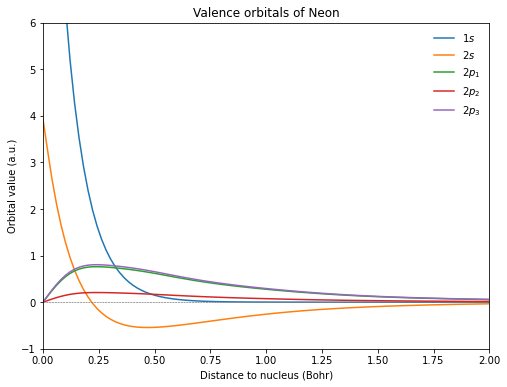

In [21]:
fig = plt.figure(1, figsize=(8,6))

plt.plot(r, mo_1s, r, mo_2s, r, mo_2p_1, r, mo_2p_2, r, mo_2p_3)

plt.axhline(y=0.0, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (0,2), ylim = (-1, 6))
plt.legend([r'$1s$', r'$2s$', r'$2p_1$', r'$2p_2$', r'$2p_3$'], loc = 'upper right', frameon = False)

plt.title(r'Valence orbitals of Neon')
plt.xlabel(r'Distance to nucleus (Bohr)')
plt.ylabel(r'Orbital value (a.u.)')

plt.show()

## Atomic sub-shell densities

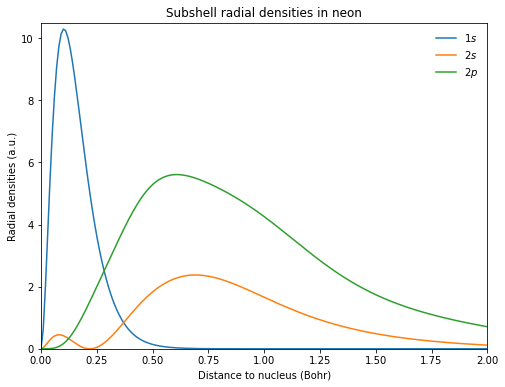

In [15]:
fig = plt.figure(2, figsize=(8,6))

# additional factor of 2 from alpha and beta spin orbitals
rad_den_1s = 4 * np.pi * r**2 * 2 * mo_1s**2 
rad_den_2s = 4 * np.pi * r**2 * 2 * mo_2s**2 
rad_den_2p = 4 * np.pi * r**2 * 2 * (mo_2p_1**2 + mo_2p_2**2 + mo_2p_3**2)

plt.plot(r, rad_den_1s, r, rad_den_2s, r, rad_den_2p)

plt.axhline(y=0.0, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (0,2), ylim = (0.0, 10.5))
plt.legend([r'$1s$', r'$2s$', r'$2p$'], loc = 'upper right', frameon = False)

plt.title(r'Subshell radial densities in neon')
plt.xlabel(r'Distance to nucleus (Bohr)')
plt.ylabel(r'Radial densities (a.u.)')

plt.show()